## Model Development

In [18]:
%reload_ext autoreload
%autoreload 1

In [30]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse as ssp
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm.auto import tqdm

from src.metrics import Gini
from src.process import load_train_test

In [31]:
def eval_gini(preds, dtrain):
    """Custom Callback to Implement Gini for Early Stopping.
    """
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

In [45]:
LABEL = "target"
NFOLDS = 3


train, test = load_train_test()

train_id = train["id"]
test_id = test["id"]
train_label = train[LABEL]


kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)

y = train[LABEL].values
drop_features = ["id", LABEL]
X = train.drop(drop_features, axis=1)

features = X.columns.tolist()
cat_features = [c for c in features if ("cat" in c and "count" not in c)]
num_features = [c for c in features if ("cat" not in c and "calc" not in c)]
ind_features = [c for c in features if "ind" in c]

### Feature Processing

In [84]:
%%time

for c in cat_features:
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

enc = OneHotEncoder()
enc.fit(train[cat_features])
X_cat = enc.transform(train[cat_features])
X_t_cat = enc.transform(test[cat_features])


count = 0
for c in ind_features:
    if count == 0:
        train["new_ind"] = train[c].astype(str) + "_"
        test["new_ind"] = test[c].astype(str) + "_"
        count += 1
    else:
        train["new_ind"] += train[c].astype(str) + "_"
        test["new_ind"] += test[c].astype(str) + "_"

cat_count_features = []
for c in cat_features + ["new_ind"]:
    d = pd.concat([train[c], test[c]]).value_counts().to_dict()
    train["%s_count" % c] = train[c].apply(lambda x: d.get(x, 0))
    test["%s_count" % c] = test[c].apply(lambda x: d.get(x, 0))
    cat_count_features.append("%s_count" % c)

train_list = [
    train[num_features + cat_count_features].values,
    X_cat,
]
test_list = [
    test[num_features + cat_count_features].values,
    X_t_cat,
]

CPU times: user 28.5 s, sys: 6.53 s, total: 35.1 s
Wall time: 35 s


### Model Params

In [23]:
N_SEEDS = 3  # of random seeds to train to reduce variance due to randomness

X = ssp.hstack(train_list).tocsr()
X_test = ssp.hstack(test_list).tocsr()

learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2_000
feature_fraction = 0.6
num_boost_round = 10_000

params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9,
          "force_row_wise": True,
          "metrics": ["auc"],
          }

### Model Fitting and Cross-Validation

In [42]:
%%time
fold_scores = []

final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))

for s in tqdm(range(N_SEEDS)):

    params['seed'] = s
    cv_train = np.zeros(len(train_label))
    cv_preds = np.zeros(len(test_id))
    kf = kfold.split(X, train_label)

    best_trees = []
    fold_scores = []

    for i, (train_fold, validate) in enumerate(kf):

        X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]

        dtrain = lgb.Dataset(X_train, label_train)
        dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgb.train(params,
                        dtrain,
                        num_boost_round,
                        valid_sets=[dtrain, dvalid],
                        feval=[eval_gini],
                        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True, first_metric_only=False)]
                       )

        best_trees.append(bst.best_iteration)

        cv_preds += bst.predict(X_test, num_iteration=bst.best_iteration)
        cv_train[validate] += bst.predict(X_validate)
        score = Gini(label_validate, cv_train[validate])
        print(f"CV Score [{i + 1} of {NFOLDS}]: {score:,.4f}")
        fold_scores.append(score)

    cv_preds /= NFOLDS
    final_cv_train += cv_train
    final_cv_pred += cv_preds

    _cv_score = Gini(train_label, cv_train)
    print(f"CV Score: {_cv_score:,.4f}")
    print("Scores by Fold: {fold_scores}")
    print(f"Best Trees: {best_trees} Avg: {np.mean(best_trees):,.4f}")
    fold_scores.append(Gini(train_label, cv_train))

  0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's auc: 0.677739	training's gini: 0.355479	valid_1's auc: 0.643587	valid_1's gini: 0.287174
Gini Score: 0.2872
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[271]	training's auc: 0.691623	training's gini: 0.383245	valid_1's auc: 0.637412	valid_1's gini: 0.274825
Gini Score: 0.2748
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's auc: 0.67194	training's gini: 0.343881	valid_1's auc: 0.643527	valid_1's gini: 0.287054
Gini Score: 0.2871
cv [3 of 3] score: 0.2828
Scores by Fold: {fold_scores}
Best Trees: [177, 271, 133] Avg: 193.6667


 33%|███▎      | 1/3 [02:52<05:44, 172.35s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's auc: 0.665372	training's gini: 0.330743	valid_1's auc: 0.644004	valid_1's gini: 0.288009
Gini Score: 0.2880
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	training's auc: 0.68948	training's gini: 0.378961	valid_1's auc: 0.639252	valid_1's gini: 0.278505
Gini Score: 0.2785
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[148]	training's auc: 0.674296	training's gini: 0.348591	valid_1's auc: 0.643523	valid_1's gini: 0.287045
Gini Score: 0.2870
cv [3 of 3] score: 0.2843
Scores by Fold: {fold_scores}
Best Trees: [104, 249, 148] Avg: 167.0000


 67%|██████▋   | 2/3 [05:30<02:44, 164.20s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	training's auc: 0.678593	training's gini: 0.357186	valid_1's auc: 0.643351	valid_1's gini: 0.286701
Gini Score: 0.2867
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	training's auc: 0.685096	training's gini: 0.370193	valid_1's auc: 0.638858	valid_1's gini: 0.277715
Gini Score: 0.2777
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	training's auc: 0.673659	training's gini: 0.347319	valid_1's auc: 0.643558	valid_1's gini: 0.287115
Gini Score: 0.2871
cv [3 of 3] score: 0.2837
Scores by Fold: {fold_scores}
Best Trees: [185, 214, 149] Avg: 182.6667


100%|██████████| 3/3 [08:21<00:00, 167.13s/it]

CPU times: user 41min 10s, sys: 9.22 s, total: 41min 20s
Wall time: 8min 21s


In [85]:
# Create DataFrames of CV and Out-of-Sample Score and Save to Disk

dfout = pd.DataFrame({'id': test_id, 'target': final_cv_pred / N_SEEDS})     # out-of-sample predictions
dfcv  = pd.DataFrame({'id': train_id, 'target': final_cv_train / N_SEEDS})   # cv predictions


dfout.to_parquet(f"data/model_scores.snap.parquet")
dfcv.to_parquet(f"data/cv_scores.snap.parquet")


dfout.to_csv(f"data/model_scores.csv", index=False)
dfcv.to_csv(f"data/cv_scores.csv", index=False)


dfall = pd.concat([
    dfcv.assign(Type="CV"),
    dfout.assign(Type="Test")])
    

### Check the Distribution of CV Scores vs. Out-of-Sample

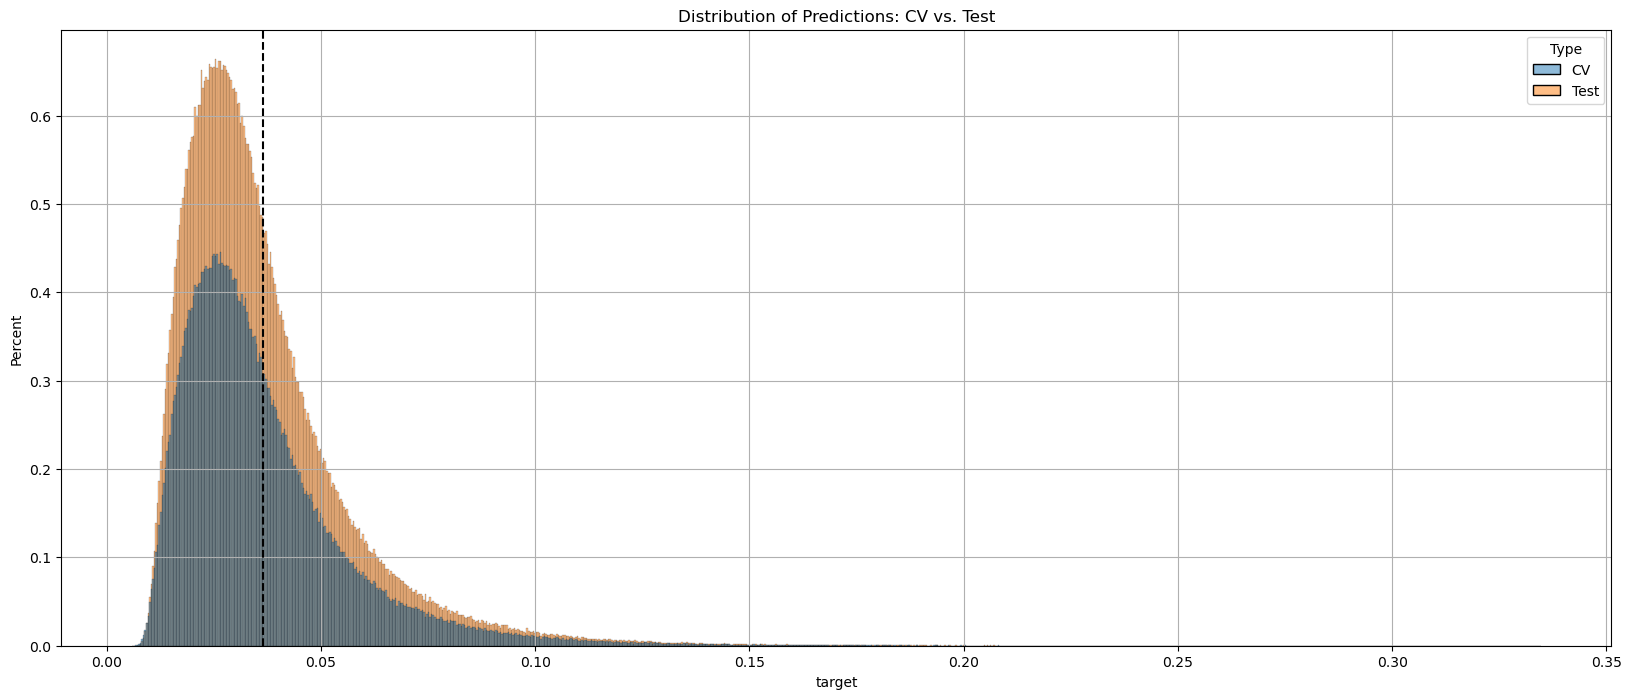

In [51]:
f, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.histplot(dfall, x="target", hue="Type", ax=ax, stat="percent")
ax.grid()
ax.axvline(train["target"].mean(), linestyle="--", color="black")
plt.title(f"Distribution of Predictions: CV vs. Test")
plt.show()

In [55]:
df_actuals = train[["id", "target"]].rename(columns={"target": "actual"})
dfscore = dfcv.merge(df_actuals)

In [ ]:
# f, ax = plt.subplots(1, 1, figsize=(20, 8))

# sns.histplot(dfscore, x="target", hue="actual", ax=ax, stat="percent")
# ax.grid()
# ax.axvline(train["target"].mean(), linestyle="--", color="black")
# plt.title(f"Distribution of Predictions: CV vs. Test")
# plt.show()

### Decision Threshold

- Test a few decision threshold to see which optimizes ROC

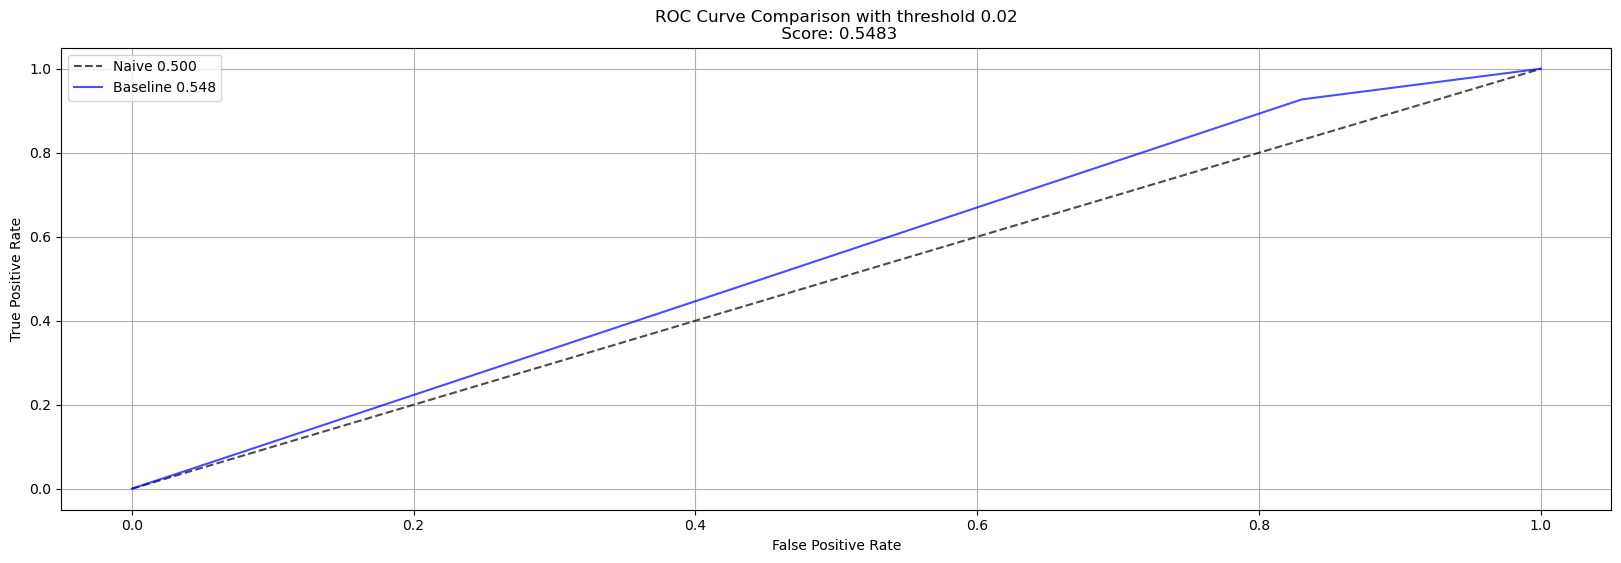

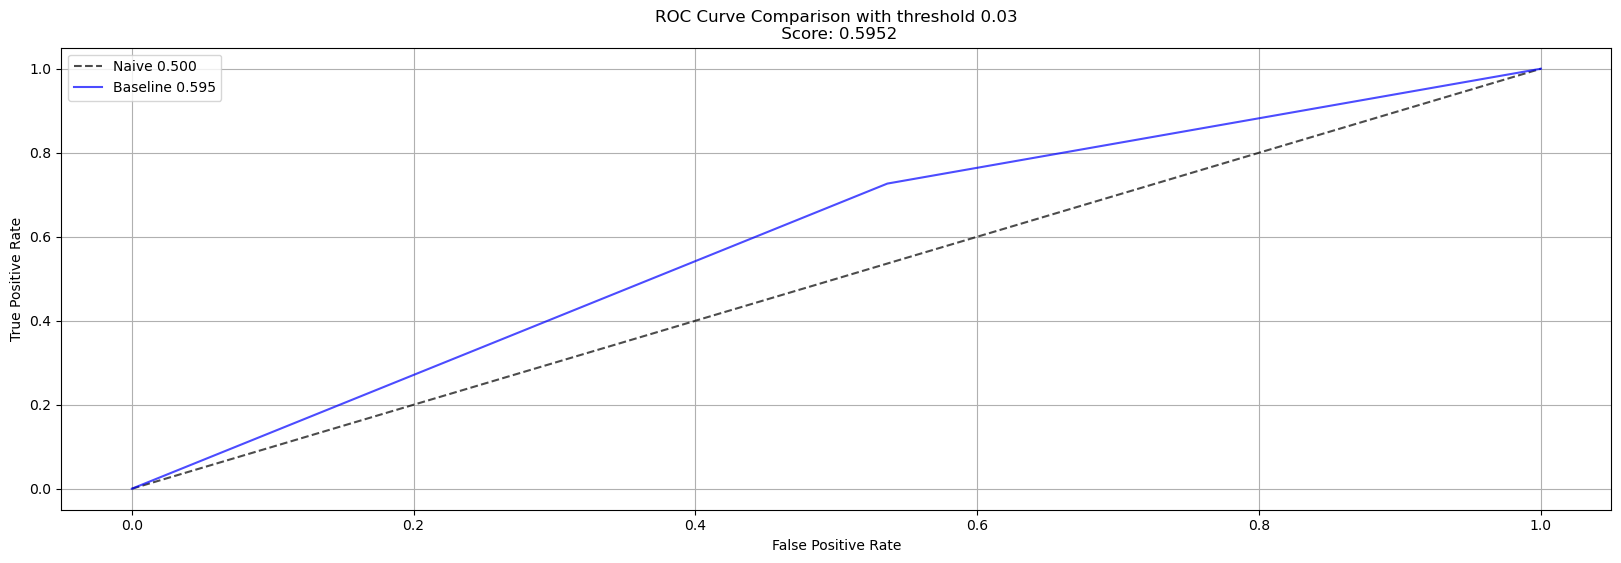

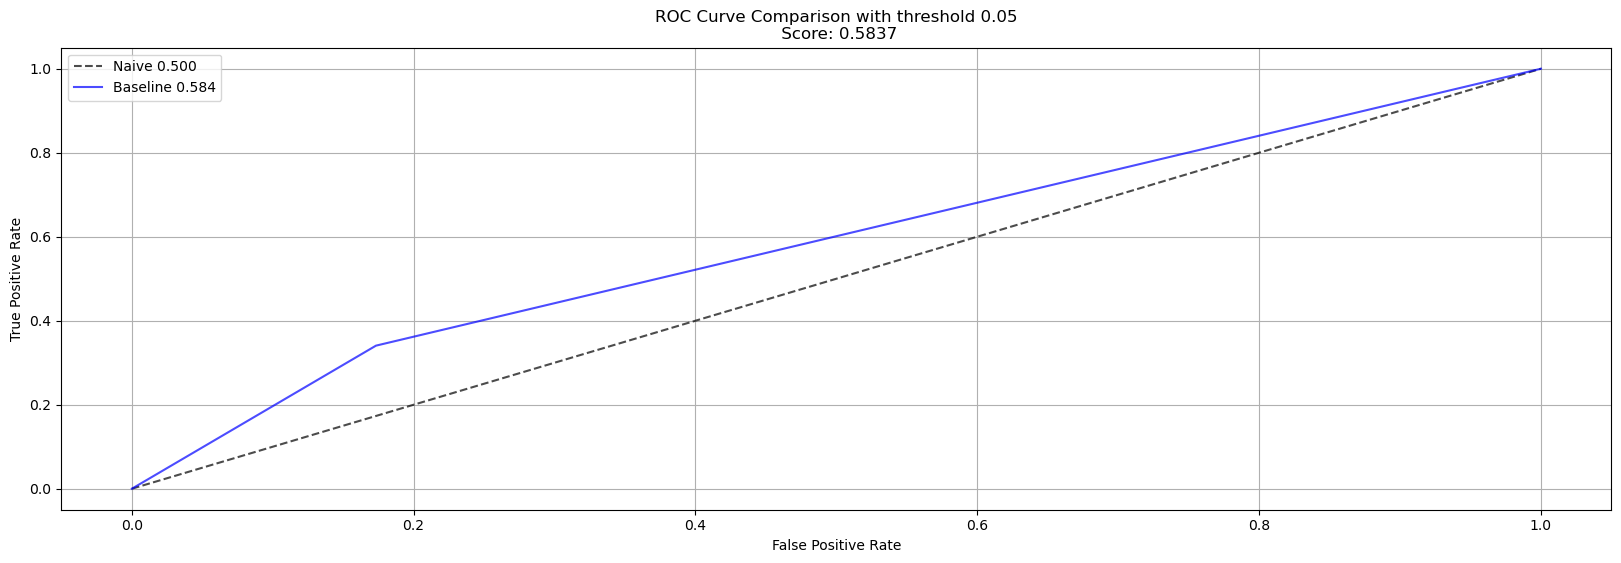

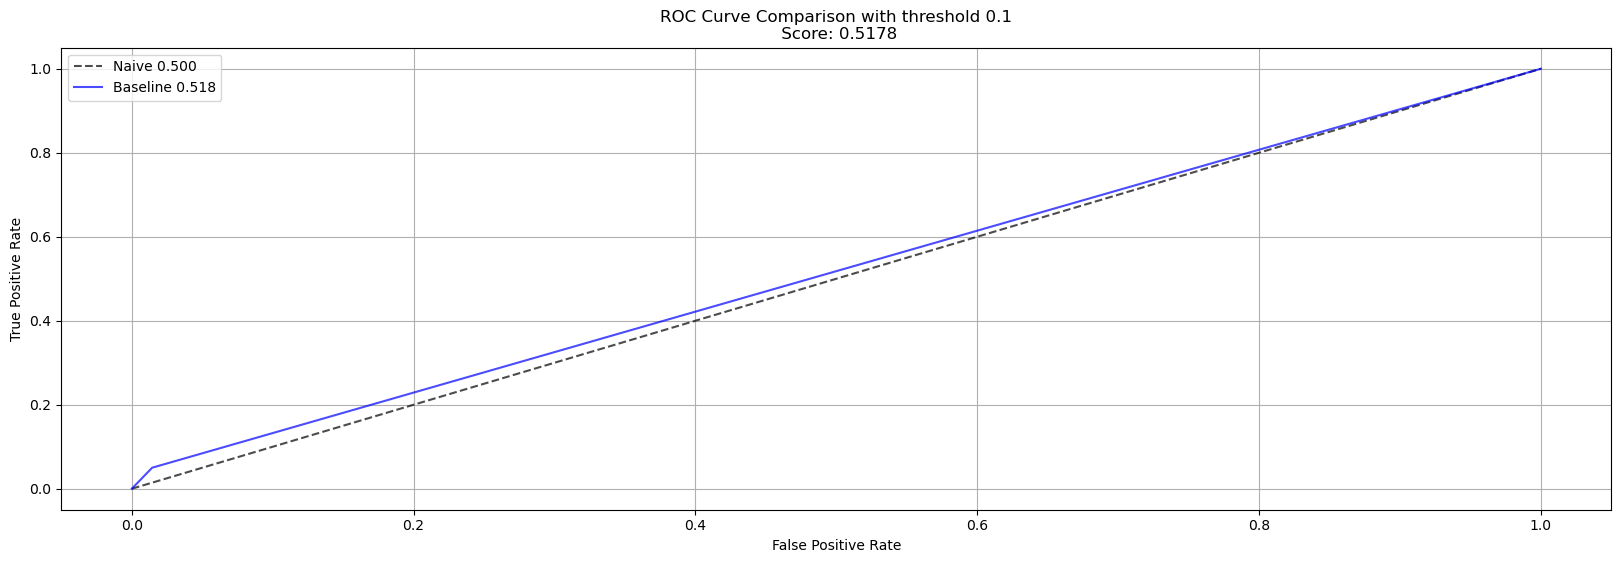

In [120]:
for thresh in [.02, .03, .05, .1]:
    dfshow["label"] = np.where(dfshow["target"] >= thresh, 1, 0)
    roc_base = roc_auc_score(dfshow["actual"], dfshow["label"])
    roc_naive = roc_auc_score(dfshow["actual"], dfshow["pred_naive"])

    fpr_baseline, tpr_baseline, _ = roc_curve(dfshow["actual"],  dfshow["label"])
    fpr_naive, tpr_naive, _ = roc_curve(dfshow["actual"],  dfshow["pred_naive"])

    plt.plot(fpr_naive, tpr_naive, label=f"Naive {roc_naive:.3f}", alpha=0.7, color="black", linestyle="--")
    plt.plot(fpr_baseline, tpr_baseline, label=f"Baseline {roc_base:.3f}", color="Blue", alpha=0.7)
    plt.legend(loc="upper left")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.rcParams["figure.figsize"] = (20, 6)
    plt.title(f'ROC Curve Comparison with threshold {thresh}\n Score: {roc_base:.4f}')
    plt.grid()
    # fname = PLOT_DIR.joinpath("roc_curve_comparison.png")
    # plt.savefig(fname)
    plt.show()

In [115]:
THRESH = .15

dfscore["pred"] = dfscore["target"]
dfscore["pred_label"] = np.where(dfscore["pred"] >= THRESH, 1, 0)
dfscore["pred_naive"] = 0
dfscore

,id,target,actual,pred,pred_label,pred_naive
0,7,0.040162,0,0.040162,0,0
1,9,0.029809,0,0.029809,0,0
2,13,0.022601,0,0.022601,0,0
3,16,0.016189,0,0.016189,0,0
4,17,0.026772,0,0.026772,0,0
...,...,...,...,...,...,...
595207,1488013,0.026457,0,0.026457,0,0
595208,1488016,0.039692,0,0.039692,0,0
595209,1488017,0.016343,0,0.016343,0,0
595210,1488021,0.025476,0,0.025476,0,0


In [116]:
print(classification_report(dfscore["actual"], dfscore["pred_label"]))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    573518
           1       0.18      0.01      0.02     21694

    accuracy                           0.96    595212
   macro avg       0.57      0.50      0.50    595212
weighted avg       0.94      0.96      0.95    595212



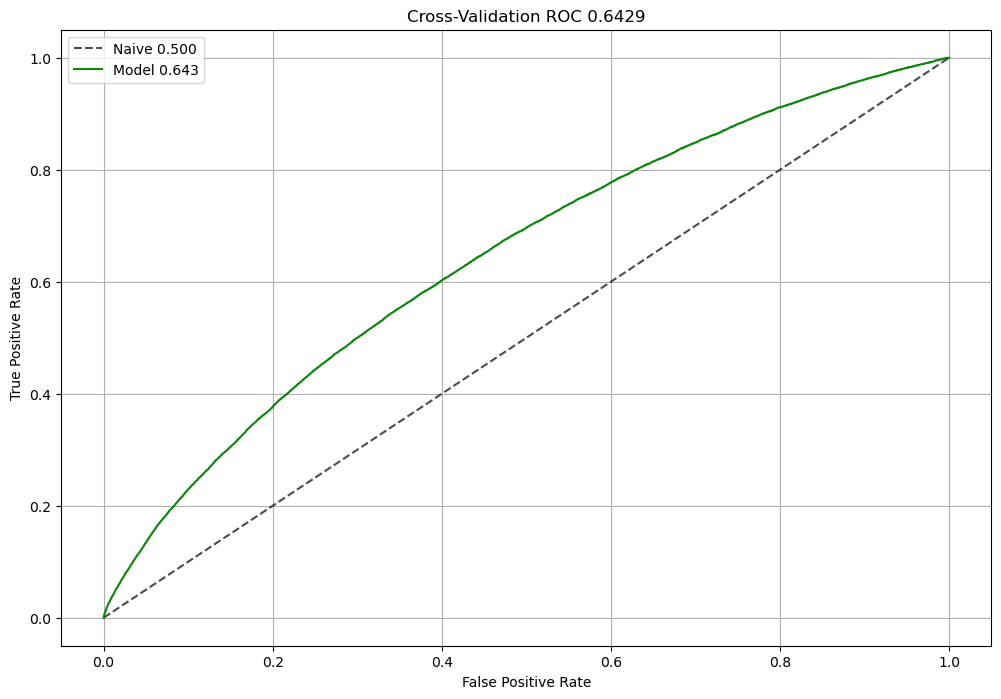

In [ ]:
roc_naive = roc_auc_score(dfscore["actual"], dfscore["pred_naive"])
roc_model = roc_auc_score(dfscore["actual"], dfscore["pred"])

fpr_naive, tpr_naive, _ = roc_curve(dfscore["actual"], dfscore["pred_naive"])

fpr, tpr, _ = roc_curve(dfscore["actual"], dfscore["pred"])

plt.plot(fpr_naive, tpr_naive, label=f"Naive {roc_naive:.3f}", alpha=0.7, color="black", linestyle="--")
plt.plot(fpr, tpr, label=f"Model {roc_model:.3f}", color="Green", alpha=0.95)

plt.legend(loc="upper left")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.rcParams["figure.figsize"] = (12, 8)
plt.title(f"Cross-Validation ROC {roc_model:.4f}")
plt.grid()
plt.show()